In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
import os
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Paths to the dataset directories
train_dir = '/content/drive/MyDrive/ComputerClassification ClaClassificationssification/train'
test_dir  = '/content/drive/MyDrive/Computer Vision/Fruits Classification/test'
val_dir   = '/content/drive/MyDrive/Computer Vision/Fruits Classification/valid'

In [ ]:
# Image size and batch
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Basic rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load datasets
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
# Class info
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)
print(f"Total number of classes: {n_classes}")

Total number of classes: 5


In [ ]:
class_names

['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

In [ ]:
# Base model
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Fine-tune top 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

In [ ]:
# Train the model
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[early_stop, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3620s 12s/step - accuracy: 0.6060 - loss: 1.0248 - val_accuracy: 0.7100 - val_loss: 0.8102 - learning_rate: 1.0000e-04
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 173s 568ms/step - accuracy: 0.8386 - loss: 0.4690 - val_accuracy: 0.7650 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 203s 570ms/step - accuracy: 0.8686 - loss: 0.3770 - val_accuracy: 0.8950 - val_loss: 0.3185 - learning_rate: 1.0000e-04
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 175s 576ms/step - accuracy: 0.8922 - loss: 0.3089 - val_accuracy: 0.9100 - val_loss: 0.2648 - learning_rate: 1.0000e-04
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 174s 573ms/step - accuracy: 0.9005 - loss: 0.2737 - val_accuracy: 0.9200 - val_loss: 0.2105 - learning_rate: 1.0000e-04
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 173s 570ms/step - accuracy: 0.9141 - loss: 0.2559 - val_accuracy: 0.9350 - val_loss: 0.2264 - learning_rate: 1.0000e-04
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# Evaluate on test data
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.9159 - loss: 0.2465
Test Accuracy: 0.92


In [ ]:
# Predictions & report
y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = test_data.classes

print(classification_report(true_labels, y_pred_labels, target_names=class_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
              precision    recall  f1-score   support

       Apple       0.82      0.90      0.86        20
      Banana       1.00      0.90      0.95        20
       Grape       0.91      1.00      0.95        20
       Mango       0.90      0.90      0.90        20
  Strawberry       1.00      0.90      0.95        20

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


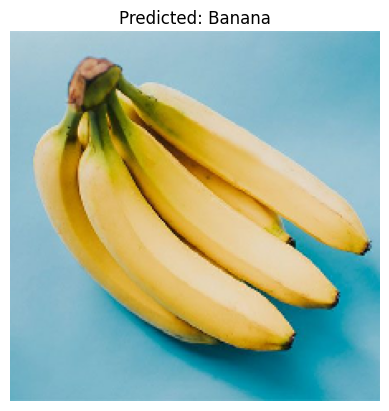

Prediction Confidence: 100.00%


In [ ]:
from tensorflow.keras.preprocessing import image



def predict_image(img_path):
    IMG_SIZE = 224

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Prediction Confidence: {np.max(predictions[0])*100:.2f}%")

predict_image('/content/drive/MyDrive/Bunch-of-bananas-67e91d5.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


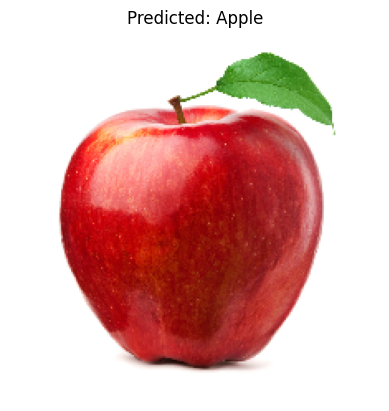

Prediction Confidence: 100.00%


In [ ]:
predict_image('/content/drive/MyDrive/apple_158989157.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


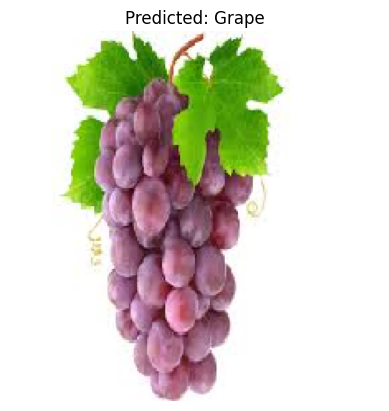

Prediction Confidence: 100.00%


In [ ]:
predict_image('/content/drive/MyDrive/grape.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


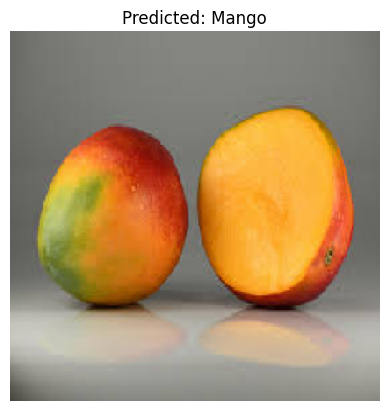

Prediction Confidence: 99.99%


In [ ]:
predict_image('/content/drive/MyDrive/mango.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


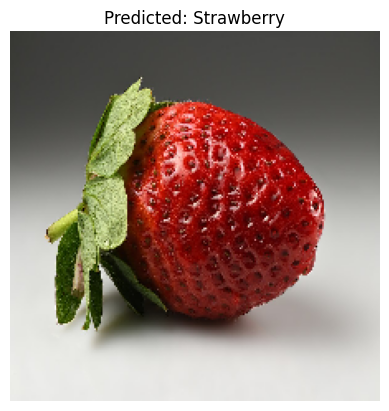

Prediction Confidence: 99.99%


In [ ]:
predict_image('/content/drive/MyDrive/Garden_strawberry_(Fragaria_×_ananassa)_single2.jpg')  # Replace 'your_image.jpg' with your image path


In [ ]:
import joblib as jb


In [ ]:
jb.dump(base_model, 'Fruit Classifier')

['Fruit Classifier']